# Title: Predict_orthologs
### Author: Mathieu Giguere

Brief: Uses machine learning to predict the resistance of FKS1-HS1 Orthologs amino acid sequences to an antifungal drug by training a model on single mutants amino acid sequences. The model uses Expasy Protscale's amino acid properties as features.

Preconditions: Needs Romain Durand's 'nt_refined_classification.csv' from his 'DMS-main' repository and 'aminoAcidProperties.txt'.



In [1]:
# importing modules and packages
import pandas as pd
import numpy as np
np.bool = np.bool_
np.int = np.int_
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import glob
import os

## Define parameters

In [2]:
drug = 'micafungin' # choices are : 'caspofungin', 'anidulafungin', 'micafungin'
strain = 'BY4741' # currently only supports 'BY4741'
locus = 'FKS1-HS1' # currently only supports 'FKS1-HS1'
assay = 'mardy' # choices are : 'orthologs' (WT orthologs), 'mardy' (mutants reported in the literature)

# Dictionary to convert 3-level resistance classification to 2-level
parse_res_class = {'deleterious':'sensitive',
                   'slightly deleterious':'sensitive',
                   'WT-like':'sensitive',
                   'intermediary':'resistant',
                   'resistant':'resistant'
                  }

## Specify paths

In [3]:
classified_nt_path = f'../aggregated_data/classified_variants/{strain}_{locus}_single/nt_refined_classification.csv'
classified_aa_path = f'../aggregated_data/classified_variants/{strain}_{locus}_single/aa_refined_classification.csv'
aminoacid_prop_path = '../data/general_use/aminoAcidProperties.txt'
mut_path = '../mardy2/Fks_mutated_hotspot_seq_210624.csv'
taxdata_path = '../orthologs/fks1_dataframe.csv'
df_outpath = f'{strain}_{locus}/'

## Make a usable dataframe from the data.

In [4]:
df = pd.read_csv(classified_nt_path, index_col=0)
drug_var = df[df.compound == drug][['compound', 'seq_type', 'Nham_aa', 'aa_seq']]
drug_var

,compound,seq_type,Nham_aa,aa_seq
628,micafungin,ortho,1.0,FLILSLRDP
629,micafungin,ortho,1.0,FLTLSLRDP
630,micafungin,ortho,2.0,FLALSFRDP
631,micafungin,ortho,2.0,FLALSIRDP
632,micafungin,ortho,2.0,FLSLSFRDP
...,...,...,...,...
937,micafungin,single,1.0,TLVLSLRDP
938,micafungin,single,1.0,TLVLSLRDP
939,micafungin,single,1.0,VLVLSLRDP
940,micafungin,single,1.0,WLVLSLRDP


## Add missing mutants et classification label

In [5]:
class_aa = pd.read_csv(classified_aa_path, index_col=0)
drug_aa = class_aa[class_aa.compound == drug][['compound','seq_type','Nham_aa','aa_seq','sensres']].rename(columns={'sensres':'resistance'})
drug_aa

,compound,seq_type,Nham_aa,aa_seq,resistance
444,micafungin,ortho,1.0,FLILSLRDP,sensitive
445,micafungin,ortho,1.0,FLTLSLRDP,sensitive
446,micafungin,ortho,2.0,FLALSFRDP,sensitive
447,micafungin,ortho,2.0,FLALSIRDP,sensitive
448,micafungin,ortho,2.0,FLSLSFRDP,resistant
...,...,...,...,...,...
898,micafungin,single,1.0,FLVGSLRDP,sensitive
902,micafungin,single,1.0,FLVKSLRDP,resistant
906,micafungin,single,1.0,FLVLSLRDN,resistant
910,micafungin,single,1.0,FLVLSLRDQ,resistant


In [6]:
annotdf = pd.merge(left = drug_var, right = drug_aa, how='outer')
annotdf

,compound,seq_type,Nham_aa,aa_seq,resistance
0,micafungin,ortho,1.0,FLILSLRDP,sensitive
1,micafungin,ortho,1.0,FLTLSLRDP,sensitive
2,micafungin,ortho,2.0,FLALSFRDP,sensitive
3,micafungin,ortho,2.0,FLALSIRDP,sensitive
4,micafungin,ortho,2.0,FLSLSFRDP,resistant
...,...,...,...,...,...
314,micafungin,single,1.0,CLVLSLRDP,resistant
315,micafungin,single,1.0,FDVLSLRDP,resistant
316,micafungin,single,1.0,FLVGSLRDP,sensitive
317,micafungin,single,1.0,FLVLSLRDN,resistant


## Import amino acid properties

In [7]:
# Amino acid properties
AAproperties = pd.read_table(aminoacid_prop_path)
AAproperties.rename(columns={'Aminoacid.1.letter': 'aa'}, inplace=True)
AAproperties

,aa,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,A,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
1,C,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,...,89,35.77,20,-14.3,-2.2,-6.8,-9.2,1.16,-0.30,1.0372
2,D,1.01,0.924,1.04,5.45,0.47,97.8,0.51,10.85,0.54,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
3,E,1.51,1.504,1.44,6.75,0.62,113.9,0.50,11.89,0.37,...,78,17.26,102,-7.5,-7.5,-16.9,-7.1,0.61,-2.90,-0.7893
4,F,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,...,81,29.40,41,14.7,13.9,13.2,19.2,1.25,1.98,1.2727
5,G,0.57,0.510,0.56,7.07,0.56,62.9,0.54,12.43,0.75,...,84,0.00,49,-2.3,-0.5,0.0,-1.2,0.61,-0.19,-0.1771
6,H,1.00,1.003,1.22,2.27,1.12,155.8,0.32,12.16,0.87,...,84,21.81,66,2.0,0.8,-3.5,-2.1,0.93,-1.44,0.1204
7,I,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,...,88,19.06,96,11.0,11.8,13.9,6.6,1.81,1.97,1.1109
8,K,1.16,1.172,1.23,5.84,0.74,115.5,0.47,11.36,0.74,...,87,21.29,56,-2.5,-3.2,0.1,-3.7,0.70,-3.46,-1.1806
9,L,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,...,85,18.78,40,15.0,10.0,8.8,20.0,1.30,1.82,0.9138


## Create training dataframe on single mutants

In [8]:
# I tried removing the two FKS1-HS1 orthologs from the training set but they contain mutations at position 641, for which the nature of the residue is important, so ultimately we need them in the training set
#ortho_list = [x for x in drug_master.loc[drug_master.seq_type == 'ortho', 'aa_seq'].unique() if x != drug_master.loc[drug_master.Nham_aa == 0, 'aa_seq'].values[0]]
#Single_master = drug_master.loc[(drug_master['seq_type'] == 'single')
#                                & (~drug_master.aa_seq.isin(ortho_list))
#                               ]
Single_master = annotdf.loc[annotdf.Nham_aa <=1]

# Explode aa_seq into many columns
Single_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Single_master

C:\Users\duran\AppData\Local\Temp\ipykernel_15288\3263073826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
C:\Users\duran\AppData\Local\Temp\ipykernel_15288\3263073826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Single_master['aa_seq'].appl

,compound,seq_type,Nham_aa,aa_seq,resistance,aa639,aa640,aa641,aa642,aa643,aa644,aa645,aa646,aa647
0,micafungin,ortho,1.0,FLILSLRDP,sensitive,F,L,I,L,S,L,R,D,P
1,micafungin,ortho,1.0,FLTLSLRDP,sensitive,F,L,T,L,S,L,R,D,P
48,micafungin,single,0.0,FLVLSLRDP,sensitive,F,L,V,L,S,L,R,D,P
49,micafungin,single,0.0,FLVLSLRDP,sensitive,F,L,V,L,S,L,R,D,P
50,micafungin,single,0.0,FLVLSLRDP,sensitive,F,L,V,L,S,L,R,D,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,micafungin,single,1.0,CLVLSLRDP,resistant,C,L,V,L,S,L,R,D,P
315,micafungin,single,1.0,FDVLSLRDP,resistant,F,D,V,L,S,L,R,D,P
316,micafungin,single,1.0,FLVGSLRDP,sensitive,F,L,V,G,S,L,R,D,P
317,micafungin,single,1.0,FLVLSLRDN,resistant,F,L,V,L,S,L,R,D,N


In [9]:
# Merge dataframe with AAproperties
AA1 = AAproperties.add_suffix('_aa639')
AA1.rename(columns={'aa_aa639': 'aa639'}, inplace=True)
Single_merged = pd.merge(left=Single_master, right=AA1, how='inner', indicator='l639', suffixes=(None, '_aa1'), on='aa639')

for i in range(640,648):
    AA = AAproperties.add_suffix(f'_aa{i}')
    AA.rename(columns={f'aa_aa{i}': f'aa{i}'}, inplace=True)
    Single_merged = pd.merge(left=Single_merged, right=AA, how='inner', indicator=f'l{i}', suffixes=(None, f'_aa{i}'),
                  on=f'aa{i}')

Single_merged

,compound,seq_type,Nham_aa,aa_seq,resistance,aa639,aa640,aa641,aa642,aa643,...,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647,l647
0,micafungin,ortho,1.0,FLILSLRDP,sensitive,F,L,I,L,S,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,micafungin,single,1.0,FLILSLRDP,sensitive,F,L,I,L,S,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,micafungin,ortho,1.0,FLTLSLRDP,sensitive,F,L,T,L,S,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,micafungin,single,1.0,FLTLSLRDP,sensitive,F,L,T,L,S,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,micafungin,single,1.0,FLTLSLRDP,sensitive,F,L,T,L,S,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,micafungin,single,1.0,FLVLSLRDV,resistant,F,L,V,L,S,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
260,micafungin,single,1.0,FLVLSLRDW,sensitive,F,L,V,L,S,...,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925,both
261,micafungin,single,1.0,FLVLSLRDY,resistant,F,L,V,L,S,...,31.53,41,3.8,8.2,6.1,5.9,1.53,0.49,0.8806,both
262,micafungin,single,1.0,FLVLSLRDN,resistant,F,L,V,L,S,...,13.28,134,-2.8,-1.6,0.8,-5.7,0.60,-1.62,-0.2693,both


In [10]:
Single_merged[['compound','seq_type','aa_seq','resistance']
             ].to_csv(f'{df_outpath}/{drug}_ML_{assay}_training_set_hotspots.csv', index=False)

In [11]:
# Get training data for machine learning.
X_train = Single_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 'Nham_aa', 'resistance',
                                      'l639', 'l640', 'l641', 'l642', 'l643', 'l644', 'l645', 'l646', 'l647',
                                      'aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647'])

X_train

,alpha_helix_chou_aa639,alpha_helix_deleage_aa639,alpha_helix_levitt_aa639,aminoacid_composition_swissprot_bairoch_aa639,antiparallel_beta_strand_lifson_aa639,average_area_buried_folding_rose_aa639,average_flexibility_bhaskaran_aa639,average_surrounding_hydrophobicity_manavalan_aa639,beta_sheet_chou_aa639,beta_sheet_deleage_aa639,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
260,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,104,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925
261,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,84,31.53,41,3.8,8.2,6.1,5.9,1.53,0.49,0.8806
262,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,94,13.28,134,-2.8,-1.6,0.8,-5.7,0.60,-1.62,-0.2693


In [12]:
y_train = Single_merged['resistance']

y_train

0      sensitive
1      sensitive
2      sensitive
3      sensitive
4      sensitive
         ...    
259    resistant
260    sensitive
261    resistant
262    resistant
263    resistant
Name: resistance, Length: 264, dtype: object

## Create Orthologs Prediction (test) dataframe

In [13]:
if assay == 'orthologs':
    Ortho_master = annotdf.loc[annotdf.Nham_aa > 1]
    lcols = ['seq_type', 'aa_seq', 'compound', 'Nham_aa', 'resistance']
elif assay == 'mardy':
    mut_full = pd.read_csv(mut_path, index_col=0)
    mut_full.rename(columns={'phenotype':'resistance', 'aa':'aa_seq'}, inplace=True)
    mut_full['resistance'].replace(to_replace={'susceptible':'sensitive'}, inplace=True)
    lcols = ['species','ortho_homolog','mutation','aa_seq','pubmedid','best degree of evidence','resistance']
    Ortho_master = mut_full[(mut_full.Hotspot == locus.split('-')[-1]) # correct hotspot (no matter the homolog)
                            & (mut_full.drug == drug.title()) # only the designated drug
                            & (~mut_full.aa_seq.str.contains('-')) # no deletion
                            & (~mut_full.aa_seq.isin(Single_merged.aa_seq.unique())) # not already in training set
                           ][lcols].reset_index(drop=True)
    
# Explode aa_seq into many columns
Ortho_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

print(len(Ortho_master))
Ortho_master

56


,species,ortho_homolog,mutation,aa_seq,pubmedid,best degree of evidence,resistance,aa639,aa640,aa641,aa642,aa643,aa644,aa645,aa646,aa647
0,Candida albicans,Fks1,D648Y,FLTLSLRYP,['18955538'],8,resistant,F,L,T,L,S,L,R,Y,P
1,Candida albicans,Fks1,F641I,ILTLSLRDP,['30895218'],-8,sensitive,I,L,T,L,S,L,R,D,P
2,Candida albicans,Fks1,F641L,LLTLSLRDP,['18955538'],8,resistant,L,L,T,L,S,L,R,D,P
3,Candida albicans,Fks1,F641S,SLTLSLRDP,"['16723566', '18955538', '20145084', '30895218']",4,resistant,S,L,T,L,S,L,R,D,P
4,Candida albicans,Fks1,P649H,FLTLSLRDH,['18955538'],8,resistant,F,L,T,L,S,L,R,D,H
5,Candida albicans,Fks1,P649L,FLTLSLRDL,['24733467'],-1,sensitive,F,L,T,L,S,L,R,D,L
6,Candida albicans,Fks1,R647G,FLTLSLGDP,"['24733467', '31520783']",1,resistant,F,L,T,L,S,L,G,D,P
7,Candida albicans,Fks1,S645F,FLTLFLRDP,"['16723566', '18955538']",4,resistant,F,L,T,L,F,L,R,D,P
8,Candida albicans,Fks1,S645P,FLTLPLRDP,"['16723566', '18955538', '20145084', '28784671...",4,resistant,F,L,T,L,P,L,R,D,P
9,Candida albicans,Fks1,S645Y,FLTLYLRDP,"['16723566', '18955538']",4,resistant,F,L,T,L,Y,L,R,D,P


In [14]:
# Merge dataframe with AAproperties
Ortho_merged = pd.merge(left=Ortho_master, right=AA1, how='inner', indicator='l639', suffixes=(None, '_aa1'), on='aa639')

for i in range(640,648):
    AA = AAproperties.add_suffix(f'_aa{i}')
    AA.rename(columns={f'aa_aa{i}': f'aa{i}'}, inplace=True)
    Ortho_merged = pd.merge(left=Ortho_merged, right=AA, how='inner', indicator=f'l{i}', suffixes=(None, f'_aa{i}'),
                  on=f'aa{i}')

Ortho_merged

,species,ortho_homolog,mutation,aa_seq,pubmedid,best degree of evidence,resistance,aa639,aa640,aa641,...,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647,l647
0,Candida albicans,Fks1,D648Y,FLTLSLRYP,['18955538'],8,resistant,F,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,Candida auris,Fks1,D642Y,FLTLSLRYP,['36920237'],8,resistant,F,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,Nakaseomyces glabrata,Fks1,D632Y,FLILSLRYP,"['19546367', '22751546', '24126582', '24153129...",7,resistant,F,L,I,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,Nakaseomyces glabrata,Fks2,D666Y,FLILSLRYP,"['24126582', '24153129']",-8,sensitive,F,L,I,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,Candida albicans,Fks1,F641I,ILTLSLRDP,['30895218'],-8,sensitive,I,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
5,Candida albicans,Fks1,F641L,LLTLSLRDP,['18955538'],8,resistant,L,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
6,Candida albicans,Fks1,F641S,SLTLSLRDP,"['16723566', '18955538', '20145084', '30895218']",4,resistant,S,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
7,Candida auris,Fks1,F635S,SLTLSLRDP,['36975998'],-8,sensitive,S,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
8,Candida tropicalis,Fks1,F650S,SLTLSLRDP,"['30895218', '31520783']",8,resistant,S,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
9,Candida auris,Fks1,F635C,CLTLSLRDP,['36975998'],8,resistant,C,L,T,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both


In [15]:
Ortho_merged[['species','ortho_homolog','mutation','aa_seq']
             ].to_csv(f'{df_outpath}/{drug}_ML_{assay}_testing_set_hotspots.csv', index=False)

In [16]:
# Get testing data for machine learning.
X_test = Ortho_merged.drop(columns=lcols+
                           ['l639', 'l640', 'l641', 'l642', 'l643', 'l644', 'l645', 'l646', 'l647',
                            'aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647'])

X_test

,alpha_helix_chou_aa639,alpha_helix_deleage_aa639,alpha_helix_levitt_aa639,aminoacid_composition_swissprot_bairoch_aa639,antiparallel_beta_strand_lifson_aa639,average_area_buried_folding_rose_aa639,average_flexibility_bhaskaran_aa639,average_surrounding_hydrophobicity_manavalan_aa639,beta_sheet_chou_aa639,beta_sheet_deleage_aa639,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,1.799,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,1.261,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
6,0.77,0.739,0.82,6.56,0.87,85.6,0.51,11.23,0.75,0.928,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,0.77,0.739,0.82,6.56,0.87,85.6,0.51,11.23,0.75,0.928,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,0.77,0.739,0.82,6.56,0.87,85.6,0.51,11.23,0.75,0.928,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,1.191,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [17]:
y_test = Ortho_merged['resistance']

y_test

0     resistant
1     resistant
2     resistant
3     sensitive
4     sensitive
5     resistant
6     resistant
7     sensitive
8     resistant
9     resistant
10    resistant
11    resistant
12    sensitive
13    resistant
14    resistant
15    sensitive
16    resistant
17    resistant
18    resistant
19    resistant
20    resistant
21    resistant
22    resistant
23    resistant
24    resistant
25    resistant
26    resistant
27    resistant
28    resistant
29    resistant
30    resistant
31    resistant
32    resistant
33    resistant
34    resistant
35    resistant
36    resistant
37    resistant
38    resistant
39    resistant
40    resistant
41    resistant
42    sensitive
43    resistant
44    sensitive
45    resistant
46    resistant
47    resistant
48    resistant
49    resistant
50    resistant
51    sensitive
52    resistant
53    sensitive
54    resistant
55    resistant
Name: resistance, dtype: object

## Machine Learning

In [18]:
# Use Gridsearch & Random Forest

print(drug)

if drug == 'caspofungin' :
    grid = {'n_estimators': [100],
            'max_features': [9, 14, 15, 17, 23, 25],
            'max_depth': [10,12,15,20,23,25],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

elif drug == 'anidulafungin' :
    grid = {'n_estimators': [100],
            'max_features': [9, 13, 17, 23, 25],
            'max_depth': [10, 12, 15, 17,20],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

elif drug == 'micafungin' :
    grid = {'n_estimators': [100],
            'max_features': [15,17,19,20,21,23],
            'max_depth': [7,8,10,12,13,14],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

else:
    print("Wrong drug")


CV_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, n_jobs=-1, cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=18), scoring='balanced_accuracy')
CV_rf.fit(X_train, y_train)

print(CV_rf.best_params_)



y_pred = CV_rf.predict(X_test)

micafungin
{'max_depth': 14, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 18}


In [19]:
# Prediction on training to evaluate overfitting. Print Balanced accuracy.
y_pred_train = CV_rf.predict(X_train)
    
bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
print(bal_acc_train)

bal_acc_test = balanced_accuracy_score(y_test, y_pred)
print(bal_acc_test)

0.9855072463768115
0.624113475177305


In [20]:
export_df = pd.DataFrame(data=[y_test,y_pred])
export_df = export_df.T
export_df.rename(columns={'resistance': 'y_test'}, inplace=True)
export_df.rename(columns={'Unnamed 0': 'y_pred'}, inplace=True)

export_df

,y_test,y_pred
0,resistant,resistant
1,resistant,resistant
2,resistant,resistant
3,sensitive,resistant
4,sensitive,resistant
5,resistant,sensitive
6,resistant,resistant
7,sensitive,resistant
8,resistant,resistant
9,resistant,resistant


In [21]:
export_df.to_csv(f'{df_outpath}/{drug}_ML_{assay}_results.csv', index=False)

In [22]:
if assay == 'orthologs': # Merge predictions with dataframe with taxonomic info
    taxdf = pd.read_csv(taxdata_path)[['Kingdom','Phylum','Species','Hotspot'+locus[-1],'Is_Human_Pathogen']]
    merged_pred = pd.concat([Ortho_merged[['aa_seq','Nham_aa','resistance']], export_df[['y_pred']]], axis=1)
    fullmerged = taxdf.rename(columns={'Hotspot'+locus[-1]: 'aa_seq'}).merge(right=merged_pred, on='aa_seq')
    display(fullmerged[fullmerged.resistance != fullmerged.y_pred].groupby('aa_seq')[['Nham_aa','resistance','y_pred']].first())

elif assay == 'mardy': # Merge predictions to get info on misclassified variants
    merged_pred = Ortho_merged[lcols]
    merged_pred['prediction'] = export_df.y_pred
    display(merged_pred[merged_pred.resistance != merged_pred.prediction])

C:\Users\duran\AppData\Local\Temp\ipykernel_15288\3429730694.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pred['prediction'] = export_df.y_pred


,species,ortho_homolog,mutation,aa_seq,pubmedid,best degree of evidence,resistance,prediction
3,Nakaseomyces glabrata,Fks2,D666Y,FLILSLRYP,"['24126582', '24153129']",-8,sensitive,resistant
4,Candida albicans,Fks1,F641I,ILTLSLRDP,['30895218'],-8,sensitive,resistant
5,Candida albicans,Fks1,F641L,LLTLSLRDP,['18955538'],8,resistant,sensitive
7,Candida auris,Fks1,F635S,SLTLSLRDP,['36975998'],-8,sensitive,resistant
15,Nakaseomyces glabrata,Fks1,F625Y,YLILSLRDP,"['24126582', '24153129', '30895218']",-8,sensitive,resistant
33,Nakaseomyces glabrata,Fks1,L630I,FLILSIRDP,"['22948870', '24126582', '24153129', '30895218']",8,resistant,sensitive
41,Nakaseomyces glabrata,Fks1,D632E,FLILSLREP,"['18378714', '19546367', '19546367', '23487382...",7,resistant,sensitive
43,Nakaseomyces glabrata,Fks1,D632G,FLILSLRGP,"['19546367', '19546367', '24829248']",7,resistant,sensitive
51,Candida albicans,Fks1,P649L,FLTLSLRDL,['24733467'],-1,sensitive,resistant
53,Nakaseomyces glabrata,Fks2,P667T,FLILSLRDT,"['19546367', '23487382', '28784671', '30895218']",-8,sensitive,resistant


In [23]:
proba = CV_rf.predict_proba(X_test)[::,1]

proba_df = pd.DataFrame(data=proba)
proba_df.to_csv(f'{df_outpath}/{drug}_ML_{assay}_ROCproba.csv', index=False)

## SHAP

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\envs\dms-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['overall_composition_mccaldon_aa643', 'aminoacid_composition_swissprot_bairoch_aa643', 'percentage_buried_janin_aa643', 'bulkiness_aa641', 'recognition_factors_aa643']


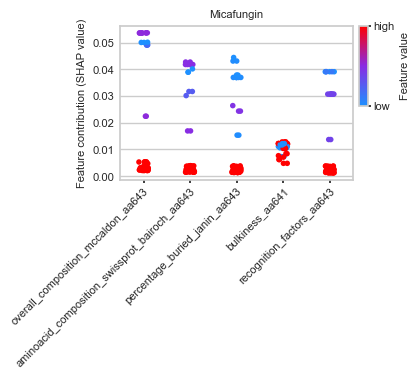

In [24]:
# Graph options
rc_dict = {'figure.figsize':(3,2),
      'font.family':'Arial',
      'font.size':8,
      'legend.title_fontsize':8, 'legend.fontsize':8,
      'axes.labelsize':8,'axes.titlesize':8,
      'xtick.labelsize':8, 'ytick.labelsize':8,
      'xtick.major.pad':2, 'ytick.major.pad':2,
      'xtick.bottom': True, 'ytick.left': False,
      'xtick.major.size':2, 'ytick.major.size':2
     }
sns.set(rc = rc_dict,
       style='whitegrid')

ccmap = sns.color_palette("blend:dodgerblue,blueviolet,red", # SHAP default cmap
                          as_cmap=True)

from matplotlib import cm
import shap
## Re-compute SHAP values
# Create SHAP explainer for the trained model (brf) and calculate SHAP values for the test data (X_test_s)
explainer = shap.Explainer(CV_rf.best_estimator_)
shap_v = explainer(X_test)

## Extract SHAP values and reshape df
# Create DataFrames for SHAP values and original data
shap_df = pd.DataFrame(shap_v.values[:,:,0])
data = pd.DataFrame(shap_v.data)
columns = X_test.columns
shap_df.columns = columns
data.columns = columns

# Function to normalize a column to the range [0, 1]
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    if min_val == max_val:
        return column
    else:
        return (column - min_val) / (max_val - min_val)

# Apply min-max scaling to each column in the original data DataFrame
data = data.apply(min_max_scaling)
# Reshape SHAP values DataFrame and original data DataFrame for plotting
shap_long = shap_df.melt(var_name='Features', value_name='Shap values')
data_long = data.melt(var_name='Features', value_name='Data')
# Concatenate SHAP values and original data for plotting
df = pd.concat([shap_long, data_long['Data']], axis=1)

# Select specific columns for the final strip plot. Using the most important features. Most important Features (mif)
fi = df
fi['Shap values'] = fi['Shap values'].abs()
feature_importance = fi.groupby(['Features'], as_index=False).mean()
feature_importance.sort_values(by=['Shap values'], ascending=False,inplace=True)
mif = feature_importance[0:5]['Features'].to_list()
print(mif)

# Create a strip plot for selected columns using SHAP values and original data
fig = sns.stripplot(data=df[df['Features'].isin(mif)], x='Features', y='Shap values', hue='Data',
                    legend=False, jitter=True, palette=ccmap, size=4, order=mif)

fig.set(xlabel='', ylabel='Feature contribution (SHAP value)')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

fig.set_title(f'{drug.title()}')

# Custom colorbar
norm_Data = plt.Normalize(0,1)
sm = cm.ScalarMappable(cmap=ccmap, norm=norm_Data)
sm.set_array([])
cax = plt.axes([0.92, 0.48, 0.03, 0.4]) # left bottom width height
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.set_ylabel('Feature value')
cbar.ax.set_yticks([0,1], ['low','high'])

plt.savefig(f'{df_outpath}/{assay}_{drug}_SHAP.svg', format='svg', dpi=300)

In [25]:
training_set_l = []
testing_set_l = []
training_paths = [f'{df_outpath}/{d}_ML_mardy_training_set_hotspots.csv' for d in ['anidulafungin','caspofungin','micafungin']]
testing_paths = [f'{df_outpath}/{d}_ML_mardy_testing_set_hotspots.csv' for d in ['anidulafungin','caspofungin','micafungin']]

for p in training_paths:
    ctrain = pd.read_csv(p)
    training_set_l.append(ctrain)

for p in testing_paths:
    ctest = pd.read_csv(p)
    ctest['compound'] = p.split('/')[2].split('_')[0]
    testing_set_l.append(ctest)
    
training_set = pd.concat(training_set_l, ignore_index=True)
testing_set = pd.concat(testing_set_l, ignore_index=True)

In [4]:
sdata = pd.read_excel('../mardy2/S1_Data.xlsx')
sdata

,Species,Paralog,Uniprot ID,Hotspot #,Hotspot sequence,Positions,Mutation,Drug,Phenotype,Best degree of evidence,References (list of PMID)
0,Aspergillus fumigatus,Fks1,Q4WLT4_ASPFU,HS1,FLTLYFKDP,675-683,S679Y,Caspofungin,resistant,1,16110824
1,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,CLTLSLRDP,641-649,F641C,Caspofungin,resistant,4,37746235
2,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Anidulafungin,resistant,4,"16723566, 18955538"
3,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Caspofungin,resistant,4,"16048935, 16048935, 16048935, 16048935, 167235..."
4,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Micafungin,resistant,4,"16723566, 18955538"
...,...,...,...,...,...,...,...,...,...,...,...
167,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,VLILSLRDP,659-667,F659V,Caspofungin,resistant,7,"22948870, 19546367, 19546367, 23487382, 241265..."
168,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,VLILSLRDP,659-667,F659V,Micafungin,resistant,7,"22948870, 19546367, 19546367, 23487382, 241265..."
169,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,YLILSLRDP,659-667,F659Y,Anidulafungin,resistant,8,"20837754, 24126582, 24126582, 24829248, 248905..."
170,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,YLILSLRDP,659-667,F659Y,Caspofungin,resistant,8,"20837754, 24126582, 24126582, 24153129, 241531..."


In [9]:
def convert_mut(pos, mut):
    pos1 = int(pos.split('-')[0])
    scer_pos0 = int(mut[1:4]) - pos1
    scer_mut = 'FLVLSLRDP'[scer_pos0] + str(639+scer_pos0) + mut[-1]
    return scer_mut

In [10]:
convert_mut('675-683', 'S679Y')

'S643Y'

In [11]:
sdata['mut_scer'] = sdata.apply(lambda row: convert_mut(row.Positions, row.Mutation), axis=1)
sdata

,Species,Paralog,Uniprot ID,Hotspot #,Hotspot sequence,Positions,Mutation,Drug,Phenotype,Best degree of evidence,References (list of PMID),mut_scer
0,Aspergillus fumigatus,Fks1,Q4WLT4_ASPFU,HS1,FLTLYFKDP,675-683,S679Y,Caspofungin,resistant,1,16110824,S643Y
1,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,CLTLSLRDP,641-649,F641C,Caspofungin,resistant,4,37746235,F639C
2,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Anidulafungin,resistant,4,"16723566, 18955538",S643F
3,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Caspofungin,resistant,4,"16048935, 16048935, 16048935, 16048935, 167235...",S643F
4,Candida albicans,Fks1,A0A1D8PCT0_CANAL,HS1,FLTLFLRDP,641-649,S645F,Micafungin,resistant,4,"16723566, 18955538",S643F
...,...,...,...,...,...,...,...,...,...,...,...,...
167,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,VLILSLRDP,659-667,F659V,Caspofungin,resistant,7,"22948870, 19546367, 19546367, 23487382, 241265...",F639V
168,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,VLILSLRDP,659-667,F659V,Micafungin,resistant,7,"22948870, 19546367, 19546367, 23487382, 241265...",F639V
169,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,YLILSLRDP,659-667,F659Y,Anidulafungin,resistant,8,"20837754, 24126582, 24126582, 24829248, 248905...",F639Y
170,Nakaseomyces glabrata,Fks2,Q6FMZ3_CANGA,HS1,YLILSLRDP,659-667,F659Y,Caspofungin,resistant,8,"20837754, 24126582, 24126582, 24153129, 241531...",F639Y


In [12]:
sdata.to_excel('../mardy2/S1_Data.xlsx')